In [1]:
# VGG16 

In [22]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels

In [11]:
# Function to load and preprocess images
def load_images(folder_path):
    images = []
    labels = []
    class_names = [name for name in os.listdir(folder_path) if not name.startswith('.')]
    class_dict = {class_name: i for i, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            
            # Add a check to ensure the image is not empty
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))  # VGG16 input size
                img = img / 255.0  # Normalize pixel values to [0, 1]
                images.append(img)
                labels.append(class_dict[class_name])

    return np.array(images), np.array(labels)


In [12]:
# Remove duplicate images based on content
def remove_duplicates(images, labels):
    hash_set = set()
    unique_images = []
    unique_labels = []

    for i in range(len(images)):
        img_hash = hash(images[i].tobytes())
        if img_hash not in hash_set:
            hash_set.add(img_hash)
            unique_images.append(images[i])
            unique_labels.append(labels[i])

    return np.array(unique_images), np.array(unique_labels)


In [13]:
# Load and preprocess data
data_folder = 'train'
images, labels = load_images(data_folder)

In [14]:
# Remove duplicates
images, labels = remove_duplicates(images, labels)


In [15]:
# Shuffle the data
images, labels = shuffle(images, labels, random_state=42)


In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create data generators for data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [17]:
# Create the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(len(np.unique(labels)), activation='softmax'))


In [18]:
# Use the legacy optimizer and specify learning_rate
optimizer_legacy = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)


In [21]:
# Compile the model
model.compile(optimizer=optimizer_legacy, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Set up callbacks
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)


In [20]:
# Train the model
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/50
58/58 [==============================] - 501s 9s/step - loss: 2.0204 - accuracy: 0.2315 - val_loss: 1.6142 - val_accuracy: 0.3769
Epoch 2/50
58/58 [==============================] - 500s 9s/step - loss: 1.3339 - accuracy: 0.4935 - val_loss: 1.1916 - val_accuracy: 0.5882
Epoch 3/50
58/58 [==============================] - 493s 9s/step - loss: 0.8855 - accuracy: 0.6836 - val_loss: 0.9817 - val_accuracy: 0.7168
Epoch 4/50
58/58 [==============================] - 486s 8s/step - loss: 0.7186 - accuracy: 0.7473 - val_loss: 0.5715 - val_accuracy: 0.8039
Epoch 5/50
58/58 [==============================] - 491s 8s/step - loss: 0.5556 - accuracy: 0.7958 - val_loss: 0.6880 - val_accuracy: 0.7865
Epoch 6/50
58/58 [==============================] - 488s 8s/step - loss: 0.5171 - accuracy: 0.8110 - val_loss: 0.6570 - val_accuracy: 0.8301
Epoch 7/50
58/58 [==============================] - 490s 8s/step - loss: 0.4642 - accuracy: 0.8410 - val_loss: 0.5226 - val_accuracy: 0.8344
Epoch 8/50
58

In [23]:
# Function to plot accuracy and loss graphs
def plot_metrics(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


In [24]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    classes = unique_labels(y_true, y_pred)
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()



15/15 [==============================] - 34s 2s/step


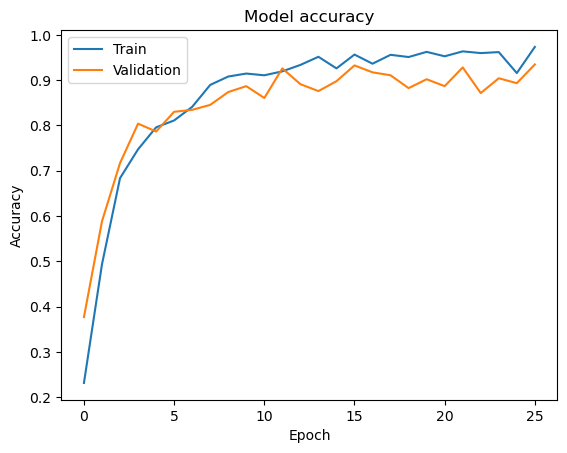

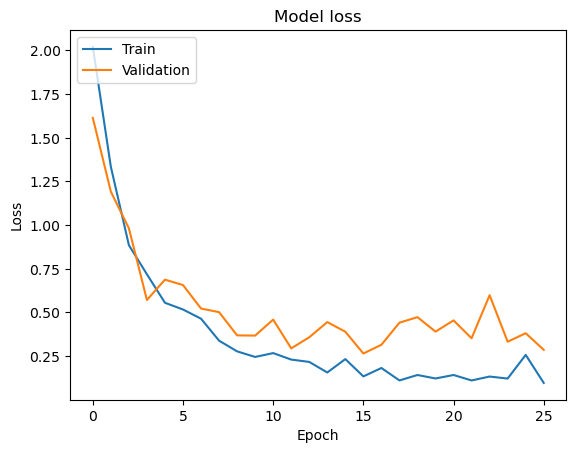

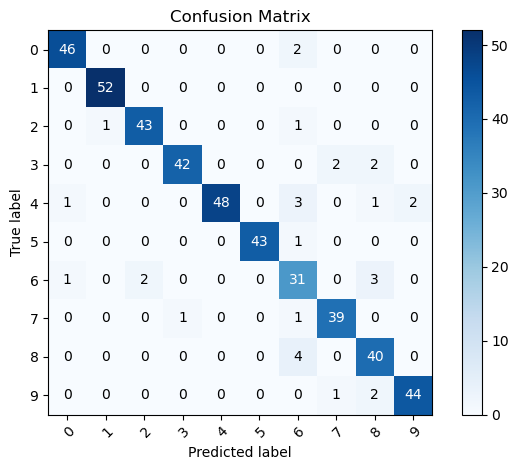

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        48
           1       0.98      1.00      0.99        52
           2       0.96      0.96      0.96        45
           3       0.98      0.91      0.94        46
           4       1.00      0.87      0.93        55
           5       1.00      0.98      0.99        44
           6       0.72      0.84      0.77        37
           7       0.93      0.95      0.94        41
           8       0.83      0.91      0.87        44
           9       0.96      0.94      0.95        47

    accuracy                           0.93       459
   macro avg       0.93      0.93      0.93       459
weighted avg       0.94      0.93      0.93       459



In [26]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Plot accuracy and loss graphs
plot_metrics(history)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_classes, classes=np.unique(labels))

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_classes))

In [32]:
import cv2
import os
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("best_model.h5")  # Replace with the actual path to your saved model

# Function to load and preprocess a single image
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to predict class labels for a list of images
def predict_images(model, image_folder):
    class_names = sorted(os.listdir(image_folder))
    images = []

    for filename in os.listdir(image_folder):
        img_path = os.path.join(image_folder, filename)
        img = preprocess_image(img_path)
        images.append(img)

    images = np.vstack(images)
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    predicted_classes = [class_names[label] for label in predicted_labels]

    return predicted_classes

# Folder containing the new images
new_images_folder = 'predict'  # Replace with the actual path

# Predict class labels for the new images
predicted_classes = predict_images(model, new_images_folder)

# Display the results
for filename, predicted_class in zip(os.listdir(new_images_folder), predicted_classes):
    print(f"Image: {filename}, Predicted Class: {predicted_class}")


2/2 [==============================] - 4s 1s/step
Image: img_421.jpeg, Predicted Class: 023.jpeg
Image: 365.jpeg, Predicted Class: 011.jpeg
Image: f2.jpeg, Predicted Class: 2.jpeg
Image: 0.jpeg, Predicted Class: 0.jpeg
Image: img_41.jpeg, Predicted Class: 00.jpeg
Image: img_381.jpeg, Predicted Class: 147.jpeg
Image: img_401.jpeg, Predicted Class: 023.jpeg
Image: 66.jpeg, Predicted Class: 012.jpeg
Image: img_21.jpeg, Predicted Class: 023.jpeg
Image: 1.jpeg, Predicted Class: 0.jpeg
Image: img_01.jpeg, Predicted Class: 00.jpeg
Image: 011.jpeg, Predicted Class: 0124.jpeg
Image: img_411.jpeg, Predicted Class: 023.jpeg
Image: 77.jpeg, Predicted Class: 012.jpeg
Image: 41.jpeg, Predicted Class: 0122.jpeg
Image: 00.jpeg, Predicted Class: 0122.jpeg
Image: img_11.jpeg, Predicted Class: 00.jpeg
Image: f5.jpeg, Predicted Class: 2.jpeg
Image: 99.jpeg, Predicted Class: 012.jpeg
Image: img_191.jpeg, Predicted Class: 1.jpeg
Image: img_31.jpeg, Predicted Class: 00.jpeg
Image: img_241.jpeg, Predicted Cla

2/2 [==============================] - 5s 1s/step


ValueError: num must be an integer with 1 <= num <= 25, not 26

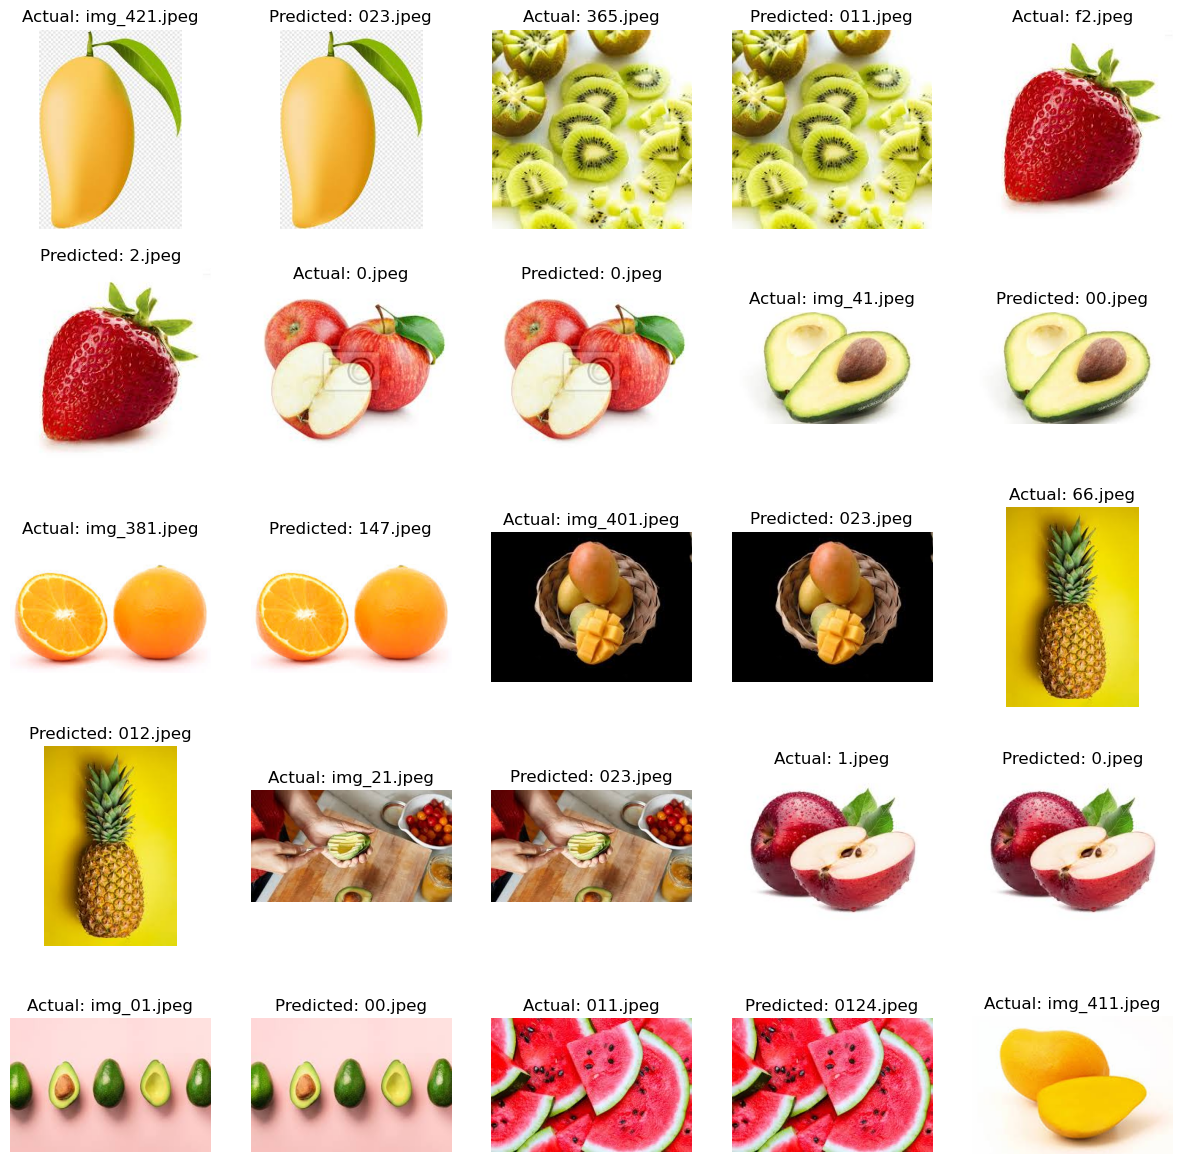

In [39]:
import cv2
import os
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model
model = load_model("best_model.h5")  # Replace with the actual path to your saved model

# Function to load and preprocess a single image
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to predict class label for a single image
def predict_single_image(model, img_path, class_names):
    img = preprocess_image(img_path)
    predictions = model.predict(img)
    predicted_label = np.argmax(predictions, axis=1)[0]
    predicted_class = class_names[predicted_label]
    return predicted_class

# Function to display images with predictions
def display_images_with_predictions(image_folder, predicted_classes):
    plt.figure(figsize=(15, 15))

    for i, (filename, predicted_class) in enumerate(zip(os.listdir(image_folder), predicted_classes), 1):
        img_path = os.path.join(image_folder, filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(5, 5, i * 2 - 1)
        plt.imshow(img)
        plt.title(f"Actual: {filename}")
        plt.axis('off')

        plt.subplot(5, 5, i * 2)
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_class}")
        plt.axis('off')

    plt.show()

# Image file path
image_folder = 'predict'  # Replace with the actual path

# Get class names from the model
class_names = sorted(os.listdir('train'))  # Assuming your training data folder has class subdirectories

# Predict class labels for the images
predicted_classes = predict_images(model, image_folder)

# Display the images with predictions
display_images_with_predictions(image_folder, predicted_classes)


1/1 [==============================] - 0s 138ms/step


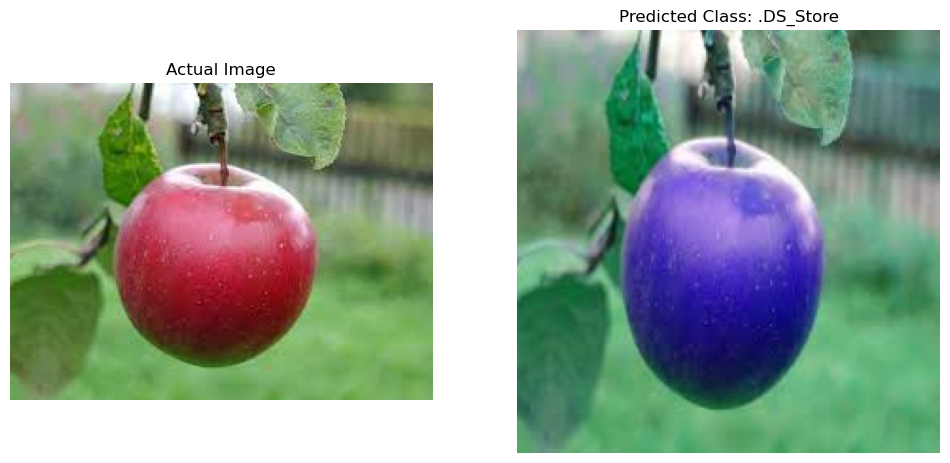

In [35]:
import cv2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model
model = load_model("best_model.h5")  # Replace with the actual path to your saved model

# Function to load and preprocess a single image
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to predict class label for a single image
def predict_single_image(model, img_path, class_names):
    img = preprocess_image(img_path)
    
    if img is not None:
        predictions = model.predict(img)
        predicted_label = np.argmax(predictions, axis=1)[0]
        predicted_class = class_names[predicted_label]
        return predicted_class
    else:
        return None

# Image file path
image_path = 'apple_red.jpeg'  # Replace with the actual path

# Get class names from the model
class_names = sorted(os.listdir('train'))  # Assuming your training data folder has class subdirectories

# Predict class label for the single image
predicted_class = predict_single_image(model, image_path, class_names)

# Display the result
if predicted_class is not None:
    # Load the actual image
    actual_img = cv2.imread(image_path)
    actual_img = cv2.cvtColor(actual_img, cv2.COLOR_BGR2RGB)

    # Load the predicted image
    predicted_img = preprocess_image(image_path)
    
    # Plot the images side by side
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(actual_img)
    plt.title("Actual Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_img[0])
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')

    plt.show()
else:
    print("Error loading the image.")


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils import shuffle

# Function to load and preprocess images
def load_images(folder_path):
    images = []
    labels = []
    class_names = [name for name in os.listdir(folder_path) if not name.startswith('.')]
    class_dict = {class_name: i for i, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            
            # Add a check to ensure the image is not empty
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))  # VGG16 input size
                img = img / 255.0  # Normalize pixel values to [0, 1]
                images.append(img)
                labels.append(class_dict[class_name])

    return np.array(images), np.array(labels)

# Remove duplicate images based on content
def remove_duplicates(images, labels):
    hash_set = set()
    unique_images = []
    unique_labels = []

    for i in range(len(images)):
        img_hash = hash(images[i].tobytes())
        if img_hash not in hash_set:
            hash_set.add(img_hash)
            unique_images.append(images[i])
            unique_labels.append(labels[i])

    return np.array(unique_images), np.array(unique_labels)

# Load and preprocess data
data_folder = 'train'
images, labels = load_images(data_folder)

# Remove duplicates
images, labels = remove_duplicates(images, labels)

# Shuffle the data
images, labels = shuffle(images, labels, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create data generators for data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(len(np.unique(labels)), activation='softmax'))

# Use the legacy optimizer and specify learning_rate
optimizer_legacy = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=optimizer_legacy, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Set up callbacks
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)
